In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as spark_sum, rand
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, expr
from pyspark.sql.functions import explode
from sklearn.datasets import fetch_kddcup99
from sklearn.metrics.pairwise import euclidean_distances


import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, DoubleType

import matplotlib.pyplot as plt

In [2]:
def initiate_session(ncores, spark=spark):
    
    spark.stop()

    spark = SparkSession.builder \
        .config("spark.executor.cores", str(ncores))\
        .master("spark://10.67.22.21:7077")\
        .appName("k-meaner")\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
        .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
        .config("spark.executor.memory", "4096m")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
        .config('spark.hadoop.fs.s3a.access.key', '79f100fb66c34d338833171110cb12fe')\
        .config('spark.hadoop.fs.s3a.secret.key', '--------------------------------')\
        .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
        .config("spark.hadoop.fs.s3a.path.style.access", "true") \
        .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
        .config("com.amazonaws.sdk.disableCertChecking","true") \
        .getOrCreate()

    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
    
    return spark, sc

ncores = 4
# 4 cores
spark, sc = initiate_session(ncores=ncores)

In [3]:
spark

In [4]:
sc

<SparkContext master=spark://10.67.22.21:7077 appName=k-meaner>

## DATASET

In [5]:
# Fetch the KDD Cup 99 dataset
kdd_data = fetch_kddcup99(as_frame=True)["frame"]

# Create a PySpark DataFrame from the sampled Pandas DataFrame
kdd = spark.createDataFrame(kdd_data)

# Print the schema of the PySpark DataFrame
kdd.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

In [6]:
# separate labels
labels = kdd.select("labels")

#drop cathegorical columns
categorical_columns = ['protocol_type', 'service', 'flag', 'labels']
kdd = kdd.drop(*categorical_columns)

kdd.createOrReplaceTempView("kdd_table")

for coll in kdd.columns:
    if spark.sql("SELECT VARIANCE(" + coll + ") FROM kdd_table").collect()[0][0] == 0:
        kdd = kdd.drop(coll)


In [7]:
for col_name in kdd.columns:
    avg_val = kdd.agg({col_name: 'avg'}).collect()[0][0]
    std_val = kdd.agg({col_name: 'stddev'}).collect()[0][0]
    kdd = kdd.withColumn(col_name, (kdd[col_name] - avg_val) / (std_val))

In [8]:
unique_labels = labels.distinct().rdd.flatMap(lambda x: x).collect()

unique_labels = [item.decode('utf-8').rstrip('.') for item in unique_labels]

print(f"Unique labels: {unique_labels}\n\nTotal amount of labels: {len(unique_labels)}")

Unique labels: ['smurf', 'pod', 'guess_passwd', 'teardrop', 'normal', 'land', 'ftp_write', 'back', 'nmap', 'ipsweep', 'multihop', 'neptune', 'warezmaster', 'imap', 'satan', 'phf', 'portsweep', 'loadmodule', 'buffer_overflow', 'perl', 'rootkit', 'warezclient', 'spy']

Total amount of labels: 23


In [9]:
attacks = unique_labels

# List of columns to be ignored

ignored_cols = ["labels", "centr", "cost", "w"]

ncols = len([c for c in kdd.columns if c not in ignored_cols]) #n° of columns ccontaining the actual data

#kdd.printSchema()

In [10]:
#%%writefile kmeans_random.py

# Function to calculate Euclidean distance between two points x and y
def euclidean_distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# Function to find the index of the minimum value in a list x
def argmin(x):
    return x.index(min(x))

# Function to initialize K-Means with random centers
def random_choice_init(data, k):
    # Select relevant columns and take k random samples
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, k))
    final = three_dim_array.reshape(three_dim_array.shape[0], -1)
    return final

# Main K-Means function
def kmeans(data, centers, max_iter=100, perc=0.999999, return_cost=False):
    count = 0

    # Get column names
    cols = data.columns

    # Initialize cost history 
    cost = [float("inf")]

    # Main K-Means loop
    while count <= max_iter:
        print("Iteration", count)

        # Define a UDF to find the index of the nearest center for each row
        argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in centers])), IntegerType())

        # Calculate the "centr" column based on the nearest center
        data = data.withColumn("centr", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

        # Update the centers based on the assigned clusters
        
        centers = np.array(data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols+['avg(centr)']]).collect())

        # Calculate the cost value per element, then sum
        get_cost = udf(lambda row: str(min([euclidean_distance(row, cen)**2 for cen in centers])))

       
        data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))

        # Calculate the new cost and add it to the cost history
        finalcost = data.select("cost").groupBy().sum().collect()[0][0]
        cost.append(finalcost)
        
        print("Cost function values", cost[count])

        # Increment the iteration count
        count += 1

        # Break if the cost change ratio is below the specified threshold
        if cost[-1] / cost[-2] > perc:
            break

    # Return the result based on whether cost history is requested
    if return_cost:
        return data, centers, cost[1:]
    else:
        return data, centers

In [11]:
# save preprocessed data

kdd = kdd.toPandas()
kdd.to_csv("data.csv", index=False)

In [12]:
# load data
kdd = spark.createDataFrame(pd.read_csv("./data.csv"))

In [13]:
def avg_cost_time_results(k, data, partitions, iterations, func, L=None):
    
    total_cost_history = np.zeros(len(partitions))
    total_time = np.zeros(len(partitions))
    
    for part in partitions:
        part_cost = np.zeros(iterations)
        part_time = np.zeros(iterations)
        for i in range(iterations):
            start_time = time.time()
            data = data.repartition(int(part))
            data = data.persist()
            r_centr = func(data, k, L)
            result, final_centroids, cost_history = kmeans(data, r_centr, max_iter=15, return_cost=True)
            part_cost[i] = cost_history[-1]
            elapsed_time = time.time() - start_time
            part_time[i] = elapsed_time
#            total_cost_history[np.where(partition==part), i] = cost_history[-1]
#            total_time[np.where(partition==part), i] = elapsed_time
        total_cost_history[np.where(partitions==part)] = np.mean(part_cost)
        total_time[np.where(partitions==part)] = np.mean(part_time)
    
    return total_cost_history, total_time


In [ ]:
ncores = 4

data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5


cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=random_choice_init)

In [ ]:
np.savez('cost.npz', cost4=cost_results)
np.savez('time.npz', time4=time_results)


# Append array2 to the existing file
#with np.load('cost.npz') as loaded_data:
#    np.savez('cost.npz', **loaded_data, time4=time_results)

#loaded_data = np.load('cost.npz')
#loaded_array1 = loaded_data['cost4']
#loaded_array2 = loaded_data['time4']

In [ ]:
ncores = 3
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [ ]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=random_choice_init)

In [ ]:
# Append array2 to the existing file
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost3=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time3=time_results)


In [ ]:
ncores = 2
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [ ]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=random_choice_init)

In [38]:
# Append array2 to the existing file
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost2=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time2=time_results)


In [15]:
ncores = 1
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [16]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=random_choice_init)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 8852765.51114059
Iteration 2


Cost function values 8051770.420248535
Iteration 3


Cost function values 7728378.385164204
Iteration 4


Cost function values 7655401.37527626
Iteration 5


Cost function values 7578135.777073393
Iteration 6


Cost function values 7482504.336871442
Iteration 7


Cost function values 7421170.664005191
Iteration 8


Cost function values 7303701.911664523
Iteration 9


Cost function values 7248045.007179875
Iteration 10


Cost function values 7245468.745813918
Iteration 11


Cost function values 7243804.341141334
Iteration 12


Cost function values 7243620.3077525245
Iteration 13


Cost function values 7243603.898861021


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9310861.598253231
Iteration 2


Cost function values 8635757.616875
Iteration 3


Cost function values 8560779.182713326
Iteration 4


Cost function values 8517788.521087594
Iteration 5


Cost function values 8494448.086682623
Iteration 6


Cost function values 8479083.853396175
Iteration 7


Cost function values 8474390.95637951
Iteration 8


Cost function values 8472912.412217831
Iteration 9


Cost function values 8470185.512934027
Iteration 10


Cost function values 8421990.70519318
Iteration 11


Cost function values 8331351.048077358
Iteration 12


Cost function values 8261356.812511476
Iteration 13


Cost function values 8171903.226394027
Iteration 14


Cost function values 8078439.037746272
Iteration 15


Cost function values 8075833.068918397


Iteration 0


Cost function values inf
Iteration 1


Cost function values 11136683.767467948
Iteration 2


Cost function values 9842836.212242952
Iteration 3


Cost function values 9648747.98923167
Iteration 4


Cost function values 9206240.363655498
Iteration 5


Cost function values 9131618.456480607
Iteration 6


Cost function values 9073940.234067991
Iteration 7


Cost function values 8944804.736969175
Iteration 8


Cost function values 8905744.39534732
Iteration 9


Cost function values 8893259.592529366
Iteration 10


Cost function values 8886594.410807353
Iteration 11


Cost function values 8884910.156202719
Iteration 12


Cost function values 8884649.659357294
Iteration 13


Cost function values 8884597.786873244
Iteration 14


Cost function values 8884575.562758692


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9614970.164399896
Iteration 2


Cost function values 9342683.304512845
Iteration 3


Cost function values 9193548.176721537
Iteration 4


Cost function values 8919109.98213686
Iteration 5


Cost function values 8825302.893116675
Iteration 6


Cost function values 8788469.937349472
Iteration 7


Cost function values 8784432.106927508
Iteration 8


Cost function values 8780671.767282309
Iteration 9


Cost function values 8777733.95675617
Iteration 10


Cost function values 8774624.281962689
Iteration 11


Cost function values 8766023.408918753
Iteration 12


Cost function values 8753118.865704924
Iteration 13


Cost function values 8720897.258794142
Iteration 14


Cost function values 8712484.208832882
Iteration 15


Cost function values 8697447.822789228


Iteration 0


Cost function values inf
Iteration 1


Cost function values 11365187.930307984
Iteration 2


Cost function values 11160825.008300103
Iteration 3


Cost function values 10699686.951265847
Iteration 4


Cost function values 9636397.374012034
Iteration 5


Cost function values 9471910.654979423
Iteration 6


Cost function values 9365959.135031642
Iteration 7


Cost function values 9301608.699794577
Iteration 8


Cost function values 9300487.662366483
Iteration 9


Cost function values 9300038.049551288
Iteration 10


Cost function values 9299636.103359351
Iteration 11


Cost function values 9299413.715983996
Iteration 12


Cost function values 9299327.141139908


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9390154.078214562
Iteration 2


Cost function values 8706379.043661924
Iteration 3


Cost function values 8476042.332382137
Iteration 4


Cost function values 8208263.360318268
Iteration 5


Cost function values 8200192.485503906
Iteration 6


Cost function values 8196433.805324587
Iteration 7


Cost function values 8192369.449059696
Iteration 8


Cost function values 8184151.287779292
Iteration 9


Cost function values 8171353.202150514
Iteration 10


Cost function values 8138904.999796278
Iteration 11


Cost function values 8128217.646196809
Iteration 12


Cost function values 8113833.892537996
Iteration 13


Cost function values 8113377.003772405
Iteration 14


Cost function values 8113357.573553862


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9161648.420519589
Iteration 2


Cost function values 8903333.555205204
Iteration 3


Cost function values 8872707.520002315
Iteration 4


Cost function values 8751335.226592796
Iteration 5


Cost function values 8491278.06667723
Iteration 6


Cost function values 8292097.311843711
Iteration 7


Cost function values 8063570.969457037
Iteration 8


Cost function values 8003116.297133836
Iteration 9


Cost function values 7954130.446556855
Iteration 10


Cost function values 7874343.346885206
Iteration 11


Cost function values 7746942.2790050665
Iteration 12


Cost function values 7664763.955641927
Iteration 13


Cost function values 7559282.5871050535
Iteration 14


Cost function values 7467240.458446036
Iteration 15


Cost function values 7464091.408374708


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8954328.295880975
Iteration 2


Cost function values 8761118.306679774
Iteration 3


Cost function values 8747388.624692257
Iteration 4


Cost function values 8741704.044743005
Iteration 5


Cost function values 8735621.20470346
Iteration 6


Cost function values 8729840.313747682
Iteration 7


Cost function values 8723561.837209566
Iteration 8


Cost function values 8701186.671505006
Iteration 9


Cost function values 8674764.452995654
Iteration 10


Cost function values 8625656.922867607
Iteration 11


Cost function values 8425967.33963139
Iteration 12


Cost function values 8173591.203461241
Iteration 13


Cost function values 7773909.481131228
Iteration 14


Cost function values 7213783.959517535
Iteration 15


Cost function values 7163131.987576251


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9176785.431199769
Iteration 2


Cost function values 9020905.380956816
Iteration 3


Cost function values 8827618.141883297
Iteration 4


Cost function values 8511940.365456361
Iteration 5


Cost function values 8502958.678048708
Iteration 6


Cost function values 8499635.675568847
Iteration 7


Cost function values 8497341.755437113
Iteration 8


Cost function values 8490145.609381175
Iteration 9


Cost function values 8478221.35788415
Iteration 10


Cost function values 8440876.411556244
Iteration 11


Cost function values 8427931.270634906
Iteration 12


Cost function values 8418447.358316494
Iteration 13


Cost function values 8417933.007203259
Iteration 14


Cost function values 8417879.93593661
Iteration 15


Cost function values 8417863.131849604


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9985999.792842578
Iteration 2


Cost function values 9677681.903402349
Iteration 3


Cost function values 9354576.202171022
Iteration 4


Cost function values 9030310.066516677
Iteration 5


Cost function values 8976021.128732685
Iteration 6


Cost function values 8964218.659834601
Iteration 7


Cost function values 8957118.950847646
Iteration 8


Cost function values 8954670.543112054
Iteration 9


Cost function values 8953305.707200903
Iteration 10


Cost function values 8950520.837320507
Iteration 11


Cost function values 8927261.889093908
Iteration 12


Cost function values 8807814.374816686
Iteration 13


Cost function values 8742717.76687203
Iteration 14


Cost function values 8739515.605024423


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9592882.133720305
Iteration 2


Cost function values 9298153.566821849
Iteration 3


Cost function values 9141842.706148455
Iteration 4


Cost function values 9019623.464143349
Iteration 5


Cost function values 8947283.485386832
Iteration 6


Cost function values 8933828.026995972
Iteration 7


Cost function values 8931478.799676245
Iteration 8


Cost function values 8928100.241887031
Iteration 9


Cost function values 8896440.397076832
Iteration 10


Cost function values 8845929.670679536
Iteration 11


Cost function values 8843997.088486712
Iteration 12


Cost function values 8843648.920394013
Iteration 13


Cost function values 8843626.227893963


Iteration 0


Cost function values inf
Iteration 1


Cost function values 10003602.638495836
Iteration 2


Cost function values 9765217.388853347
Iteration 3


Cost function values 9703595.100251501
Iteration 4


Cost function values 9577545.722632805
Iteration 5


Cost function values 9288488.643264217
Iteration 6


Cost function values 8990283.915449306
Iteration 7


Cost function values 8830843.079991369
Iteration 8


Cost function values 8717680.262463905
Iteration 9


Cost function values 8714214.835086644
Iteration 10


Cost function values 8713670.475802839
Iteration 11


Cost function values 8713220.88137283
Iteration 12


Cost function values 8713014.427642576
Iteration 13


Cost function values 8712928.645935599


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9481872.580279224
Iteration 2


Cost function values 9263349.012111306
Iteration 3


Cost function values 9051344.38771184
Iteration 4


Cost function values 9024059.348493794
Iteration 5


Cost function values 8998299.275880372
Iteration 6


Cost function values 8936109.064693661
Iteration 7


Cost function values 8934312.72164412
Iteration 8


Cost function values 8933810.221318604
Iteration 9


Cost function values 8933677.493710773
Iteration 10


Cost function values 8933640.201293219
Iteration 11


Cost function values 8933596.12703806
Iteration 12


Cost function values 8925831.452345535
Iteration 13


Cost function values 8701784.087636514
Iteration 14


Cost function values 8304684.32714599
Iteration 15


Cost function values 8304452.941856056


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9654436.670585668
Iteration 2


Cost function values 9121972.207116177
Iteration 3


Cost function values 9100049.053180043
Iteration 4


Cost function values 9085985.160746524
Iteration 5


Cost function values 8699506.724331744
Iteration 6


Cost function values 8592673.254035296


Iteration 0


Cost function values inf
Iteration 1


Cost function values 10031164.160861613
Iteration 2


Cost function values 9725820.735633649
Iteration 3


Cost function values 9422784.749632511
Iteration 4


Cost function values 9359811.03613976
Iteration 5


Cost function values 9349110.472310254
Iteration 6


Cost function values 9326126.89229588
Iteration 7


Cost function values 9271531.171244524
Iteration 8


Cost function values 9183483.874269586
Iteration 9


Cost function values 9084908.68510615
Iteration 10


Cost function values 9026873.272550818
Iteration 11


Cost function values 8936169.752971912
Iteration 12


Cost function values 8841076.793576857
Iteration 13


Cost function values 8833523.35943857
Iteration 14


Cost function values 8825906.247675354
Iteration 15


Cost function values 8813734.231297059


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9935499.47280436
Iteration 2


Cost function values 9291899.616785996
Iteration 3


Cost function values 9101744.026027532
Iteration 4


Cost function values 9045682.441496488
Iteration 5


Cost function values 8998439.188880432
Iteration 6


Cost function values 8931699.65635942
Iteration 7


Cost function values 8907496.685340162
Iteration 8


Cost function values 8898573.282245476
Iteration 9


Cost function values 8897471.44235125
Iteration 10


Cost function values 8893947.073353924
Iteration 11


Cost function values 8880125.871073183
Iteration 12


Cost function values 8867128.343367573
Iteration 13


Cost function values 8853622.581893781
Iteration 14


Cost function values 8827795.53826514
Iteration 15


Cost function values 8814872.076605566


Iteration 0


Cost function values inf
Iteration 1


Cost function values 11628748.580616154
Iteration 2


Cost function values 10903418.3263459
Iteration 3


Cost function values 9980864.821689587
Iteration 4


Cost function values 9377230.113768017
Iteration 5


Cost function values 9306160.510935552
Iteration 6


Cost function values 9293237.994533313
Iteration 7


Cost function values 9278230.073437897
Iteration 8


Cost function values 9263113.276515463
Iteration 9


Cost function values 9257251.521429386
Iteration 10


Cost function values 9238137.155434998
Iteration 11


Cost function values 9225350.214903576
Iteration 12


Cost function values 9221393.902706115
Iteration 13


Cost function values 9214788.940827044
Iteration 14


Cost function values 9207708.033940116
Iteration 15


Cost function values 9206817.215578869


Iteration 0


Cost function values inf
Iteration 1


Cost function values 10046891.251553018
Iteration 2


Cost function values 9724271.81770206
Iteration 3


Cost function values 9615467.204080598
Iteration 4


Cost function values 9573068.789063945
Iteration 5


Cost function values 9390897.49221953
Iteration 6


Cost function values 9277790.507897448
Iteration 7


Cost function values 9215294.365739794
Iteration 8


Cost function values 9199846.809751585
Iteration 9


Cost function values 9197649.731873304
Iteration 10


Cost function values 9197515.853465598
Iteration 11


Cost function values 9197506.065217286


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9489764.218646219
Iteration 2


Cost function values 8983055.855834823
Iteration 3


Cost function values 8781985.07747746
Iteration 4


Cost function values 8238128.0517373765
Iteration 5


Cost function values 8233892.146591223
Iteration 6


Cost function values 8225533.026504147
Iteration 7


Cost function values 8225005.134772975
Iteration 8


Cost function values 8223736.722249256
Iteration 9


Cost function values 8205321.609676299
Iteration 10


Cost function values 8146674.236696805
Iteration 11


Cost function values 8144869.94587479
Iteration 12


Cost function values 8144544.552492385
Iteration 13


Cost function values 8144478.106447594
Iteration 14


Cost function values 8144467.902139473


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9715512.65804205
Iteration 2


Cost function values 9110596.275413642
Iteration 3


Cost function values 8946893.111710928
Iteration 4


Cost function values 8911781.867410908
Iteration 5


Cost function values 8907262.16391623
Iteration 6


Cost function values 8864938.185998801
Iteration 7


Cost function values 8837966.697420698
Iteration 8


Cost function values 8711601.811302966
Iteration 9


Cost function values 8573372.537904216
Iteration 10


Cost function values 8510576.939071888
Iteration 11


Cost function values 8386112.6987533495
Iteration 12


Cost function values 8364297.929355703
Iteration 13


Cost function values 8363377.985922361
Iteration 14


Cost function values 8362622.257294303
Iteration 15


Cost function values 8361280.07299366


In [19]:
# Append array2 to the existing file
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost1=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time1=time_results)


In [35]:
cost_data = np.load('cost.npz')
time_data = np.load('time.npz')

cost4 = cost_data['cost4']
cost3 = cost_data['cost3']
cost2 = cost_data['cost2']
cost1 = cost_data['cost1']
time4 = time_data['time4']
time3 = time_data['time3']
time2 = time_data['time2']
time1 = time_data['time1']

cost_matrix = np.column_stack((cost1, cost2, cost3, cost4))
time_matrix = np.column_stack((time1, time2, time3, time4))


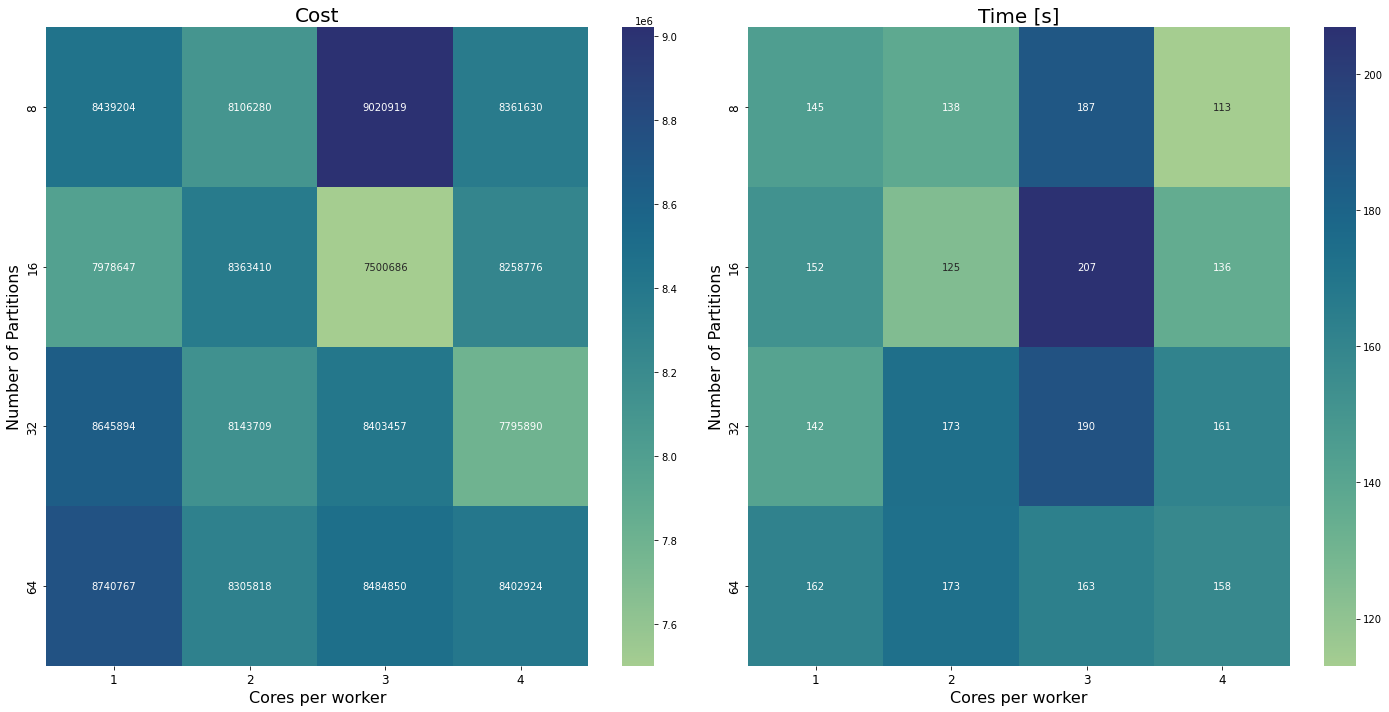

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(cost_matrix, ax=axes[0], cmap='crest', annot=True, fmt='.0f', cbar=True, yticklabels=[8,16,32,64],  
            xticklabels=[1,2,3,4])


axes[0].set_title('Cost', fontsize=20)
axes[0].set_xlabel("Cores per worker", fontsize=16)
axes[0].set_ylabel("Number of Partitions", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)


# Plot heatmap in the second subplot (bottom)
sns.heatmap(time_matrix, ax=axes[1], cmap='crest', annot=True, fmt='.0f', cbar=True, yticklabels=[8,16,32,64], 
            xticklabels=[1,2,3,4])

axes[1].set_title('Time [s]', fontsize=20)
axes[1].set_xlabel("Cores per worker", fontsize=16)
axes[1].set_ylabel("Number of Partitions", fontsize=16)
axes[1].tick_params(axis='both', labelsize=12)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# PARALLEL KMEANS

In [14]:
    
def kmeans_Lloyd(X, centroids, k, max_iters=100, tol=1e-7):
    
    """ Run the sequential LLoyd algorithm given data X, centroids and k number of clusters."""

    costs = []

    for _ in range(max_iters):
        # Step 1: Assign each data point to the nearest centroid
        distances = euclidean_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids based on the assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Calculate the cost function (sum of squared distances to centroids)
        cost = np.sum(np.min(distances, axis=1))
        costs.append(cost)

        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) <= tol:
            break
        
        centroids = new_centroids
    
    return centroids, labels, costs



In [15]:
def kmeans_ll(data, k, L): 
    
    """ || kmeans initialization of k centroids elements. X is the data, L the oversampling factor."""
    
    
    cols = data.columns
    n_samples, n_features = data.count(), len(data.columns)
    centroids = np.zeros((1, n_features))
    
    # Step 1: Choose one random point as the first centroid
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, 1))
    centroids[0] = three_dim_array.reshape(three_dim_array.shape[0], -1)
    
    # Define a UDF to find psi
    # Calculate the distance using the UDF and collect the result
    distance_udf = udf(lambda row: ((float(euclidean_distance(row, centroids[0])))), DoubleType())

    distance = data.withColumn("distance", distance_udf(array([c for c in cols if c not in ignored_cols])))

    # Sum the distances
    psi = distance.select(spark_sum(col("distance"))).collect()[0][0]
    #print(psi)

    

    # Calculate psi
    #psi = spark_sum(distance_udf(array([c for c in cols if c not in ignored_cols])).collect())

    
    for j in range(1, int(np.log(psi))):

        # Step 2: Compute distances from each point to the nearest centroid and define probabilities
        min_distance_udf = udf(lambda row: (float(min([euclidean_distance(row, c) for c in centroids]))), DoubleType())
        data = data.withColumn("probs", min_distance_udf(array([c for c in cols if c not in ignored_cols])))
        # Calculate the sum of the "probs" column
        total_sum = data.select(spark_sum(col("probs"))).collect()[0][0]
        # Normalize the "probs" column by dividing each row's value by the total sum
        data = data.withColumn("probs", col("probs")*L / total_sum)
        
        # Sample and add centroids
        # Generate a random column for filtering
        data = data.withColumn("rand_col", rand())

        # Filter and select the rows where 'rand_col' is less than 'probs' to get n_samples
        selected_data = data.filter(col("rand_col") < col("probs")).select([col(c) for c in data.columns if c not in ['rand_col','centr','cost','probs']]).collect()

        #print("centroids", centroids)
        #print("selected_data", selected_data)
        if selected_data != []:
            centroids = np.concatenate((centroids, selected_data), axis=0)
                
    if len(centroids) > k:
                
        #A SORT OF K MEANS ++ INITIALIAZATION FOR Lloyd ITERATIONS ON CENTROIDS       
        cc = np.copy(centroids)
        p_centroids = np.zeros((k, n_features))

        for j in range(0, k):
            
            # Define weights
            w = np.zeros(len(cc))

            # Create new column with the index of the nearest center for each row
            argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in cc])), IntegerType())
            data = data.withColumn("index", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

            #w = np.array(data.groupBy("index").count().collect())
            # Group by 'centroid_inddex' and count the occurrences, renaming the count column
            centroid_counts = data.groupBy("index").count()
            # Order by ascending index value
            centroid_counts = centroid_counts.sort("index")
            # Calculate the sum of counts
            total_count = centroid_counts.select(spark_sum(col("count"))).collect()[0][0]
            # Normalize the "probs" column by dividing each row's value by the total sum
            renormalized_counts = centroid_counts.withColumn("count", col("count")/ total_count).select(col("count")).collect()
            probs = np.array(renormalized_counts).flatten()

            next_centroid_idx = np.random.choice(len(probs), p=probs)
            p_centroids[j] = cc[next_centroid_idx]
            cc = np.delete(cc, next_centroid_idx, axis=0)

        #print(len(centroids), len(p_centroids))
        # K MEANS Lloyd ITERATIONS ON CENTROIDS

        final_centroids, __, _ = kmeans_Lloyd(centroids, p_centroids, k)
    else:
        final_centroids = centroids
        
    return final_centroids


In [19]:
ncores = 4
# 4 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [20]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=kmeans_ll, L=1)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 8269921.025551179
Iteration 2


Cost function values 8140511.79373426
Iteration 3


Cost function values 7777839.072673103
Iteration 4


Cost function values 7420955.258362146
Iteration 5


Cost function values 7411477.325418943
Iteration 6


Cost function values 7392736.828353294
Iteration 7


Cost function values 7387588.582491585
Iteration 8


Cost function values 7386907.837436475
Iteration 9


Cost function values 7376417.364115431
Iteration 10


Cost function values 7373053.125636206


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8426775.71135472
Iteration 2


Cost function values 8186402.265693026
Iteration 3


Cost function values 7906350.014302466
Iteration 4


Cost function values 7840478.358222374
Iteration 5


Cost function values 7838243.717296434
Iteration 6


Cost function values 7838176.058341695
Iteration 7


Cost function values 7838162.770927761


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7509351.3090652395
Iteration 2


Cost function values 7281541.546690758
Iteration 3


Cost function values 7032876.706607126
Iteration 4


Cost function values 6526391.08474685
Iteration 5


Cost function values 6478028.7149979025
Iteration 6


Cost function values 6457840.618253756
Iteration 7


Cost function values 6456809.954216204
Iteration 8


Cost function values 6456795.704460197
Iteration 9


Cost function values 6456771.978470916


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7663660.479378299
Iteration 2


Cost function values 7510803.15770679
Iteration 3


Cost function values 7496418.8464526
Iteration 4


Cost function values 7496006.018592266
Iteration 5


Cost function values 7495484.675813722
Iteration 6


Cost function values 7488435.966135354
Iteration 7


Cost function values 7480009.0009751525
Iteration 8


Cost function values 7467078.062369413
Iteration 9


Cost function values 7384852.35639932
Iteration 10


Cost function values 7091177.987326314
Iteration 11


Cost function values 7090116.762526503
Iteration 12


Cost function values 7090044.0464624185


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7886244.58829662
Iteration 2


Cost function values 7595642.1417351235
Iteration 3


Cost function values 6866600.357164064
Iteration 4


Cost function values 6722177.066212295
Iteration 5


Cost function values 6703765.527707356
Iteration 6


Cost function values 6700338.445869565
Iteration 7


Cost function values 6700183.232173748
Iteration 8


Cost function values 6700107.467116035
Iteration 9


Cost function values 6700017.095325375
Iteration 10


Cost function values 6699783.414018571
Iteration 11


Cost function values 6698977.986593045
Iteration 12


Cost function values 6692360.618782343
Iteration 13


Cost function values 6625199.980911098
Iteration 14


Cost function values 6378284.13554287
Iteration 15


Cost function values 6294452.869018687


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8026176.222032573
Iteration 2


Cost function values 7701187.483424856
Iteration 3


Cost function values 7272951.954901913
Iteration 4


Cost function values 7025427.683231149
Iteration 5


Cost function values 6999124.224555449
Iteration 6


Cost function values 6978935.235997101
Iteration 7


Cost function values 6965606.167959941
Iteration 8


Cost function values 6963233.007646094
Iteration 9


Cost function values 6961454.914059628
Iteration 10


Cost function values 6952911.854351052
Iteration 11


Cost function values 6946231.4455901235
Iteration 12


Cost function values 6936303.883689794
Iteration 13


Cost function values 6905288.771256552
Iteration 14


Cost function values 6671069.666659693
Iteration 15


Cost function values 6607418.094753605


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8945472.808986252
Iteration 2


Cost function values 8652068.049076641
Iteration 3


Cost function values 8535722.858151678
Iteration 4


Cost function values 8480979.874749701
Iteration 5


Cost function values 8437818.106146617
Iteration 6


Cost function values 8152803.374514289
Iteration 7


Cost function values 8062619.292292031
Iteration 8


Cost function values 8051350.16099642
Iteration 9


Cost function values 8046537.895212323
Iteration 10


Cost function values 8046100.195637241
Iteration 11


Cost function values 8046075.505356843


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7811191.271232223
Iteration 2


Cost function values 7762471.818688796
Iteration 3


Cost function values 7761108.429534717
Iteration 4


Cost function values 7760739.454448087
Iteration 5


Cost function values 7760637.991179349
Iteration 6


Cost function values 7760604.6828947365


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8227484.117238312
Iteration 2


Cost function values 8128257.351082404
Iteration 3


Cost function values 8095922.4570214795
Iteration 4


Cost function values 8064780.187056883
Iteration 5


Cost function values 7963581.248723173
Iteration 6


Cost function values 7751376.919555237
Iteration 7


Cost function values 7721719.339626918
Iteration 8


Cost function values 7720841.0396279665
Iteration 9


Cost function values 7720826.131520493


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8741292.596448967
Iteration 2


Cost function values 8347073.166445503
Iteration 3


Cost function values 8274847.286233761
Iteration 4


Cost function values 8270212.9108818
Iteration 5


Cost function values 8265625.146316392
Iteration 6


Cost function values 8253459.163179118
Iteration 7


Cost function values 8218631.535062763
Iteration 8


Cost function values 8217468.105826387
Iteration 9


Cost function values 8217458.585426921


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7706536.279651544
Iteration 2


Cost function values 7410544.37215846
Iteration 3


Cost function values 7236764.373423364
Iteration 4


Cost function values 6948289.384631008
Iteration 5


Cost function values 6911080.964682689
Iteration 6


Cost function values 6872789.853068702
Iteration 7


Cost function values 6649534.877028786
Iteration 8


Cost function values 6576287.833558832
Iteration 9


Cost function values 6572062.928640385
Iteration 10


Cost function values 6551526.765775404
Iteration 11


Cost function values 6462617.431930091
Iteration 12


Cost function values 6380154.151299032
Iteration 13


Cost function values 6308379.167270652
Iteration 14


Cost function values 6183383.523944245
Iteration 15


Cost function values 6174765.606708227


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7984059.870850485
Iteration 2


Cost function values 7749498.97833026
Iteration 3


Cost function values 7740191.550399822
Iteration 4


Cost function values 7717666.453744309
Iteration 5


Cost function values 7540274.268114807
Iteration 6


Cost function values 7513626.004825237
Iteration 7


Cost function values 7509268.929484389
Iteration 8


Cost function values 7504896.822615153
Iteration 9


Cost function values 7480013.979088632
Iteration 10


Cost function values 7470508.435324555
Iteration 11


Cost function values 7468182.831099515
Iteration 12


Cost function values 7467788.959561975
Iteration 13


Cost function values 7467615.842393571
Iteration 14


Cost function values 7467468.131762
Iteration 15


Cost function values 7467356.472362778


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8078459.872728918
Iteration 2


Cost function values 7834211.49826612
Iteration 3


Cost function values 7187761.837900756
Iteration 4


Cost function values 7135955.633882228
Iteration 5


Cost function values 7122622.7367663765
Iteration 6


Cost function values 7117178.8894470595
Iteration 7


Cost function values 7111889.5402047895
Iteration 8


Cost function values 7104381.24480465
Iteration 9


Cost function values 7093104.905445609
Iteration 10


Cost function values 7076266.008636314
Iteration 11


Cost function values 7071768.345644472
Iteration 12


Cost function values 7071740.269442966


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7031086.559562484
Iteration 2


Cost function values 6885857.163502625
Iteration 3


Cost function values 6728085.146482298
Iteration 4


Cost function values 6664184.666575581
Iteration 5


Cost function values 6634740.663945308
Iteration 6


Cost function values 6374862.193346249
Iteration 7


Cost function values 6250498.243566422
Iteration 8


Cost function values 6243640.875553875
Iteration 9


Cost function values 6243283.1682301825
Iteration 10


Cost function values 6243016.525747596
Iteration 11


Cost function values 6242972.103257328
Iteration 12


Cost function values 6242933.1505969


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7785150.827431099
Iteration 2


Cost function values 7163241.43573367
Iteration 3


Cost function values 7054570.339247383
Iteration 4


Cost function values 6910006.964579418
Iteration 5


Cost function values 6878247.626007235
Iteration 6


Cost function values 6873171.610310072
Iteration 7


Cost function values 6872781.297807239


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7491996.422742489
Iteration 2


Cost function values 7283026.071028074
Iteration 3


Cost function values 7021922.651546589
Iteration 4


Cost function values 6944947.199353196
Iteration 5


Cost function values 6932551.080099719
Iteration 6


Cost function values 6921143.753598227
Iteration 7


Cost function values 6908130.457241156
Iteration 8


Cost function values 6870010.149407309
Iteration 9


Cost function values 6858107.9086189065
Iteration 10


Cost function values 6852291.564592005
Iteration 11


Cost function values 6851504.7617764855
Iteration 12


Cost function values 6851438.148268116


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8076366.550553857
Iteration 2


Cost function values 7510722.469185557
Iteration 3


Cost function values 7399334.478372407
Iteration 4


Cost function values 7381419.123149613
Iteration 5


Cost function values 7378431.028992664
Iteration 6


Cost function values 7377098.039464501
Iteration 7


Cost function values 7376166.4402665105
Iteration 8


Cost function values 7374940.043702613
Iteration 9


Cost function values 7372491.287317283
Iteration 10


Cost function values 7368206.409880281
Iteration 11


Cost function values 7362540.260494702
Iteration 12


Cost function values 7356363.80214418
Iteration 13


Cost function values 7183807.052910174
Iteration 15


Cost function values 7151061.9722436


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8325409.687669214
Iteration 2


Cost function values 7834169.750821729
Iteration 3


Cost function values 7572944.058913539
Iteration 4


Cost function values 7479292.02305587
Iteration 5


Cost function values 7196256.476498363
Iteration 6


Cost function values 7143249.881539711
Iteration 7


Cost function values 7139236.550877873
Iteration 8


Cost function values 7137480.815307941
Iteration 9


Cost function values 7135924.598889214
Iteration 10


Cost function values 7134033.205916687
Iteration 11


Cost function values 7112427.27916671
Iteration 12


Cost function values 7015411.5896853795
Iteration 13


Cost function values 6928445.934827229
Iteration 14


Cost function values 6854686.392304574
Iteration 15


Cost function values 6728011.644851858


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7351072.067180905
Iteration 2


Cost function values 7046095.132544785
Iteration 3


Cost function values 6838766.329093295
Iteration 4


Cost function values 6826780.748292962
Iteration 5


Cost function values 6811165.124217028
Iteration 6


Cost function values 6435737.49583349
Iteration 7


Cost function values 6282453.556390196
Iteration 8


Cost function values 6276449.58491418
Iteration 9


Cost function values 6275521.765833915
Iteration 10


Cost function values 6275305.383301743
Iteration 11


Cost function values 6275139.477222576
Iteration 12


Cost function values 6274766.41587795
Iteration 13


Cost function values 6274329.1861423785
Iteration 14


Cost function values 6274079.930696348
Iteration 15


Cost function values 6273846.633702012


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7410570.060043658
Iteration 2


Cost function values 6936486.54868148
Iteration 3


Cost function values 6719537.01742651
Iteration 4


Cost function values 6630775.041386303
Iteration 5


Cost function values 6304606.974205933
Iteration 6


Cost function values 6146076.820573558
Iteration 7


Cost function values 5888553.121533298
Iteration 8


Cost function values 5858391.857604074
Iteration 9


Cost function values 5857563.487179228
Iteration 10


Cost function values 5857452.074208085


In [21]:
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost4_parallel=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time4_parallel=time_results)


In [22]:
ncores = 3
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [23]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=kmeans_ll, L=1)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 8566614.00827029
Iteration 2


Cost function values 8499590.298632408
Iteration 3


Cost function values 8261203.711386436
Iteration 4


Cost function values 7825007.353585646
Iteration 5


Cost function values 7819424.231097931
Iteration 6


Cost function values 7819063.895619089
Iteration 7


Cost function values 7811054.023358021
Iteration 8


Cost function values 7810823.688784687


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8369871.868648311
Iteration 2


Cost function values 8047268.403829883
Iteration 3


Cost function values 7885213.42078173
Iteration 4


Cost function values 7854829.335187004
Iteration 5


Cost function values 7853246.523200553
Iteration 6


Cost function values 7853145.667296995


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8889264.156464668
Iteration 2


Cost function values 8585627.473322548
Iteration 3


Cost function values 8509742.690059746
Iteration 4


Cost function values 8471121.450436
Iteration 5


Cost function values 8433463.467549445
Iteration 6


Cost function values 8415627.366266506
Iteration 7


Cost function values 8372284.449826368
Iteration 8


Cost function values 8341633.906851883
Iteration 9


Cost function values 8056544.971687337
Iteration 10


Cost function values 8055908.050972194
Iteration 11


Cost function values 8055757.004506735
Iteration 12


Cost function values 8055737.113940863
Iteration 13


Cost function values 8055724.0689830715
Iteration 14


Cost function values 8055674.707548367
Iteration 15


Cost function values 8055526.277446398


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8058341.107678286
Iteration 2


Cost function values 7856277.109335127
Iteration 3


Cost function values 7660438.578365293
Iteration 4


Cost function values 7211687.51564943
Iteration 5


Cost function values 7209417.5841090195
Iteration 6


Cost function values 7208638.672993904
Iteration 7


Cost function values 7207554.495793973
Iteration 8


Cost function values 7207339.912061901


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8576931.550314957
Iteration 2


Cost function values 8391474.65920219
Iteration 3


Cost function values 8231272.631230807
Iteration 4


Cost function values 8165767.734066318
Iteration 5


Cost function values 8145557.778870767
Iteration 6


Cost function values 8129582.2583310045
Iteration 7


Cost function values 8096592.745180601
Iteration 8


Cost function values 8085114.072263715
Iteration 9


Cost function values 8080982.590037167
Iteration 10


Cost function values 8080915.500425138


Iteration 0


Cost function values inf
Iteration 1


Cost function values 5812526.966222126
Iteration 2


Cost function values 5778204.035712211
Iteration 3


Cost function values 5764982.121462093
Iteration 4


Cost function values 5761297.856515039
Iteration 5


Cost function values 5756747.194253907
Iteration 6


Cost function values 5716088.057413021
Iteration 7


Cost function values 5458102.383373421
Iteration 8


Cost function values 5389107.198794723
Iteration 9


Cost function values 5346421.447777835
Iteration 10


Cost function values 5312390.21814118
Iteration 11


Cost function values 5312079.091505086
Iteration 12


Cost function values 5312011.322646343
Iteration 13


Cost function values 5311996.995379855


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7325852.681482478
Iteration 2


Cost function values 7166085.562697991
Iteration 3


Cost function values 7115776.246805951
Iteration 4


Cost function values 7085446.812992405
Iteration 5


Cost function values 7008992.835355965
Iteration 6


Cost function values 6713286.467766374
Iteration 7


Cost function values 6661072.350988903
Iteration 8


Cost function values 6654477.272517282
Iteration 9


Cost function values 6651105.7935234895
Iteration 10


Cost function values 6650218.99767732
Iteration 11


Cost function values 6649343.290743546
Iteration 12


Cost function values 6648741.949543067
Iteration 13


Cost function values 6648472.17786759
Iteration 14


Cost function values 6648158.412943027
Iteration 15


Cost function values 6647611.342628955


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8969555.825328292
Iteration 2


Cost function values 8879372.237218779
Iteration 3


Cost function values 8746680.93022744
Iteration 4


Cost function values 8604365.812096613
Iteration 5


Cost function values 8591385.090719609
Iteration 6


Cost function values 8586550.050524374
Iteration 7


Cost function values 8585572.54515928
Iteration 8


Cost function values 8585560.912936235


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7109235.748543962
Iteration 2


Cost function values 6932650.9697101405
Iteration 3


Cost function values 6868165.166428157
Iteration 4


Cost function values 6860503.488205772
Iteration 5


Cost function values 6860273.031937182
Iteration 6


Cost function values 6860248.599699773
Iteration 7


Cost function values 6860237.13961529


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8072257.504802444
Iteration 2


Cost function values 7923754.2016087705
Iteration 3


Cost function values 7881616.196785998
Iteration 4


Cost function values 7863408.516840412
Iteration 5


Cost function values 7850328.336179292
Iteration 6


Cost function values 7835252.581878329
Iteration 7


Cost function values 7815896.649583349
Iteration 8


Cost function values 7814788.488678683
Iteration 9


Cost function values 7814662.05503255


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7737951.007970252
Iteration 2


Cost function values 7303614.010959401
Iteration 3


Cost function values 7245399.272987895
Iteration 4


Cost function values 7072491.183517996
Iteration 5


Cost function values 6816660.036409909
Iteration 6


Cost function values 6684815.25840475
Iteration 7


Cost function values 6649292.428999606
Iteration 8


Cost function values 6642670.965421927
Iteration 9


Cost function values 6640726.780390122
Iteration 10


Cost function values 6640597.04038526
Iteration 11


Cost function values 6640574.036280744
Iteration 12


Cost function values 6640562.665640383


Iteration 0


Cost function values inf
Iteration 1


Cost function values 5899320.729979334
Iteration 2


Cost function values 5340792.747896598
Iteration 3


Cost function values 5070048.41596342
Iteration 4


Cost function values 5038299.717933336
Iteration 5


Cost function values 5032739.181363741
Iteration 6


Cost function values 5032389.17411342
Iteration 7


Cost function values 5032286.39971124
Iteration 8


Cost function values 5032222.178133234
Iteration 9


Cost function values 5032173.863109964
Iteration 10


Cost function values 5032086.48168155
Iteration 11


Cost function values 5032014.340337178
Iteration 12


Cost function values 5031983.434116647
Iteration 13


Cost function values 5031963.802103175
Iteration 14


Cost function values 5031940.159221766
Iteration 15


Cost function values 5031894.772690867


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6949836.782112541
Iteration 2


Cost function values 6727153.202325311
Iteration 3


Cost function values 6680505.398617066
Iteration 4


Cost function values 6636097.347865235
Iteration 5


Cost function values 6523492.097828151
Iteration 6


Cost function values 6441301.57643985
Iteration 7


Cost function values 6299656.183711343
Iteration 8


Cost function values 6279886.972095365
Iteration 9


Cost function values 6275676.863139072
Iteration 10


Cost function values 6273877.873855366
Iteration 11


Cost function values 6272552.749938734
Iteration 12


Cost function values 6271596.194704433
Iteration 13


Cost function values 6270740.847447223
Iteration 14


Cost function values 6269805.504031737
Iteration 15


Cost function values 6268912.6319622565


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7356882.499986643
Iteration 2


Cost function values 7039003.047074227
Iteration 3


Cost function values 6981520.301560708
Iteration 4


Cost function values 6969095.6142412685
Iteration 5


Cost function values 6958641.023161714
Iteration 6


Cost function values 6948277.462266432
Iteration 7


Cost function values 6945650.024895327
Iteration 8


Cost function values 6941851.912478404
Iteration 9


Cost function values 6937361.335923126
Iteration 10


Cost function values 6924068.384995427
Iteration 11


Cost function values 6840110.923626077
Iteration 12


Cost function values 6811236.7046059305
Iteration 13


Cost function values 6802952.435493814
Iteration 14


Cost function values 6799231.136765788
Iteration 15


Cost function values 6798171.966245841


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6209450.920273919
Iteration 2


Cost function values 5605362.4949769275
Iteration 3


Cost function values 5226689.7157243285
Iteration 4


Cost function values 5176574.671308964
Iteration 5


Cost function values 5169459.865645823
Iteration 6


Cost function values 5158568.995994583
Iteration 7


Cost function values 4866468.219677994
Iteration 8


Cost function values 4844417.250784304
Iteration 9


Cost function values 4844382.546318904


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8212101.779547759
Iteration 2


Cost function values 8123847.7606958775
Iteration 3


Cost function values 8121560.46342149
Iteration 4


Cost function values 8121316.380553752
Iteration 5


Cost function values 8121240.26585026
Iteration 6


Cost function values 8121219.238038151
Iteration 7


Cost function values 8121210.514450147


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7914587.326682208
Iteration 2


Cost function values 7852619.113988604
Iteration 3


Cost function values 7798504.888549295
Iteration 4


Cost function values 7663805.607040226
Iteration 5


Cost function values 7584940.425912444
Iteration 6


Cost function values 7540496.751941186
Iteration 7


Cost function values 7512787.390996311
Iteration 8


Cost function values 7505761.396728329
Iteration 9


Cost function values 7504376.810738174
Iteration 10


Cost function values 7502254.098576626
Iteration 11


Cost function values 7481857.571192624
Iteration 12


Cost function values 7438645.082992453
Iteration 13


Cost function values 7436607.42165671
Iteration 14


Cost function values 7436162.39937927
Iteration 15


Cost function values 7435968.773743719


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9062985.365474606
Iteration 2


Cost function values 9006539.017773328
Iteration 3


Cost function values 8890475.705782907
Iteration 4


Cost function values 8593644.072969059
Iteration 5


Cost function values 8529810.091904579
Iteration 6


Cost function values 8522776.699547965
Iteration 7


Cost function values 8521871.17450928
Iteration 8


Cost function values 8521668.922280699
Iteration 9


Cost function values 8521635.698347446


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7360278.32976466
Iteration 2


Cost function values 7109359.267102617
Iteration 3


Cost function values 6762890.324828
Iteration 4


Cost function values 6249157.444726034
Iteration 5


Cost function values 6230470.919937765
Iteration 6


Cost function values 6215581.95599034
Iteration 7


Cost function values 6214695.845938041
Iteration 8


Cost function values 6214289.357529486
Iteration 9


Cost function values 6213985.827978631
Iteration 10


Cost function values 6207553.855080965
Iteration 11


Cost function values 6187241.750433534
Iteration 12


Cost function values 6185938.160939603
Iteration 13


Cost function values 6185756.229753713
Iteration 14


Cost function values 6185688.753321035
Iteration 15


Cost function values 6185637.841775454


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7268183.407834082
Iteration 2


Cost function values 7057594.366959786
Iteration 3


Cost function values 6970152.185500652
Iteration 4


Cost function values 6708913.246051662
Iteration 5


Cost function values 6666421.397877344
Iteration 6


Cost function values 6664822.430546069
Iteration 7


Cost function values 6664737.6838532835


In [24]:
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost3_parallel=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time3_parallel=time_results)


In [25]:
ncores = 2
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [26]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=kmeans_ll, L=1)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 8354874.748781584
Iteration 2


Cost function values 8325229.471378352
Iteration 3


Cost function values 8321680.148011171
Iteration 4


Cost function values 8320522.32587577
Iteration 5


Cost function values 8320374.562982689
Iteration 6


Cost function values 8320335.977015009
Iteration 7


Cost function values 8320318.381252203


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8667917.65495011
Iteration 2


Cost function values 8627810.240211092
Iteration 3


Cost function values 8624548.829491979
Iteration 4


Cost function values 8624298.578292198
Iteration 5


Cost function values 8624214.676208377
Iteration 6


Cost function values 8624146.593674462
Iteration 7


Cost function values 8624127.962607425


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8144118.607121841
Iteration 2


Cost function values 8036730.013132428
Iteration 3


Cost function values 7563402.418338357
Iteration 4


Cost function values 7290682.863694417
Iteration 5


Cost function values 7224296.372506005
Iteration 6


Cost function values 7203681.310018206
Iteration 7


Cost function values 7199574.556894855
Iteration 8


Cost function values 7197660.496914491
Iteration 9


Cost function values 7191336.387975068
Iteration 10


Cost function values 7108737.986664987
Iteration 11


Cost function values 7060180.050108681
Iteration 12


Cost function values 7044410.615154367
Iteration 13


Cost function values 7037216.720051044
Iteration 14


Cost function values 7033314.020336822
Iteration 15


Cost function values 7030061.934048214


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8259160.374820749
Iteration 2


Cost function values 7938197.437378868
Iteration 3


Cost function values 7883462.383549816
Iteration 4


Cost function values 7771523.530532649
Iteration 5


Cost function values 7735699.784804033
Iteration 6


Cost function values 7731439.79204203
Iteration 7


Cost function values 7728529.866743502
Iteration 8


Cost function values 7648630.792727429
Iteration 9


Cost function values 7387970.313274028
Iteration 10


Cost function values 7372720.39014777
Iteration 11


Cost function values 7369396.869623641
Iteration 12


Cost function values 7369326.805544819
Iteration 13


Cost function values 7369317.3755999245


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6207391.0363083435
Iteration 2


Cost function values 6179768.604481284
Iteration 3


Cost function values 6177804.971589651
Iteration 4


Cost function values 6177628.571012929
Iteration 5


Cost function values 6177610.777474829


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8726263.136588516
Iteration 2


Cost function values 8586735.33474206
Iteration 3


Cost function values 8459786.432083474
Iteration 4


Cost function values 8456489.395179745
Iteration 5


Cost function values 8440886.125426233
Iteration 6


Cost function values 8408972.391529052
Iteration 7


Cost function values 8405046.772614527
Iteration 8


Cost function values 8404490.146626374
Iteration 9


Cost function values 8404436.035237396


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8186564.082968568
Iteration 2


Cost function values 7561545.169647781
Iteration 3


Cost function values 7397514.852440267
Iteration 4


Cost function values 7340018.892649233
Iteration 5


Cost function values 7327971.541090557
Iteration 6


Cost function values 7324447.522241207
Iteration 7


Cost function values 7324317.423966725
Iteration 8


Cost function values 7324274.2950783735
Iteration 9


Cost function values 7324218.393418887
Iteration 10


Cost function values 7324208.479858886


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8681123.208938375
Iteration 2


Cost function values 8323721.2649996225
Iteration 3


Cost function values 7576681.62754272
Iteration 4


Cost function values 7526616.617110003
Iteration 5


Cost function values 7509773.082134953
Iteration 6


Cost function values 7442844.1961530335
Iteration 7


Cost function values 7357557.765081301
Iteration 8


Cost function values 7344192.62661137
Iteration 9


Cost function values 7340788.67694979
Iteration 10


Cost function values 7340453.259755864
Iteration 11


Cost function values 7340419.2053246545
Iteration 12


Cost function values 7340286.390680145
Iteration 13


Cost function values 7340218.4764536675
Iteration 14


Cost function values 7340206.5428006165


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6549062.603372925
Iteration 2


Cost function values 6066360.526015696
Iteration 3


Cost function values 6005296.733281256
Iteration 4


Cost function values 5976924.409656064
Iteration 5


Cost function values 5973643.675486339
Iteration 6


Cost function values 5973263.810003764
Iteration 7


Cost function values 5973193.180914964
Iteration 8


Cost function values 5972958.360812153
Iteration 9


Cost function values 5972930.151477054


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7969799.139160047
Iteration 2


Cost function values 7141967.327386727
Iteration 3


Cost function values 7051523.36157461
Iteration 4


Cost function values 7028470.733639221
Iteration 5


Cost function values 7017203.344429787
Iteration 6


Cost function values 6997919.151230039
Iteration 7


Cost function values 6974043.150888105
Iteration 8


Cost function values 6925112.901999099
Iteration 9


Cost function values 6778204.622589558
Iteration 10


Cost function values 6552564.58532748
Iteration 11


Cost function values 6474738.715007668
Iteration 12


Cost function values 6440214.297308581
Iteration 13


Cost function values 6433880.976333807
Iteration 14


Cost function values 6429848.692673099
Iteration 15


Cost function values 6421984.8339546025


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8217962.561471173
Iteration 2


Cost function values 8012238.014454634
Iteration 3


Cost function values 7864995.577098352
Iteration 4


Cost function values 7373521.128476355
Iteration 5


Cost function values 7343685.256923505
Iteration 6


Cost function values 7342678.28127079
Iteration 7


Cost function values 7334520.317551696
Iteration 8


Cost function values 7334037.639459785


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8390374.274523066
Iteration 2


Cost function values 8125982.65870892
Iteration 3


Cost function values 7786075.574384497
Iteration 4


Cost function values 7458254.295242887
Iteration 5


Cost function values 7440032.655054571
Iteration 6


Cost function values 7424928.469284132
Iteration 7


Cost function values 7140278.981502354
Iteration 8


Cost function values 7118608.665086301


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7565455.100472536
Iteration 2


Cost function values 7455042.520679808
Iteration 3


Cost function values 7188069.655737261
Iteration 4


Cost function values 6501028.959103554
Iteration 5


Cost function values 6223139.043653214
Iteration 6


Cost function values 6218193.414492303
Iteration 7


Cost function values 6214531.523006305
Iteration 8


Cost function values 6214235.397221562
Iteration 9


Cost function values 6214133.253660258
Iteration 10


Cost function values 6214093.342265457
Iteration 11


Cost function values 6214058.441596489
Iteration 12


Cost function values 6214005.190723241
Iteration 13


Cost function values 6213889.194822621
Iteration 14


Cost function values 6213724.477427814
Iteration 15


Cost function values 6213617.992576624


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8118975.79136975
Iteration 2


Cost function values 7857373.921490677
Iteration 3


Cost function values 7222388.901056729
Iteration 4


Cost function values 7217421.599168442
Iteration 5


Cost function values 7216868.247787515
Iteration 6


Cost function values 7216734.56309575
Iteration 7


Cost function values 7216716.728929325


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9136264.126793811
Iteration 2


Cost function values 9001906.157452581
Iteration 3


Cost function values 8759033.287129855
Iteration 4


Cost function values 8690179.668216573
Iteration 5


Cost function values 8686917.009176468
Iteration 6


Cost function values 8686251.233635508
Iteration 7


Cost function values 8685816.037696887
Iteration 8


Cost function values 8685463.588465596
Iteration 9


Cost function values 8685156.964162342
Iteration 10


Cost function values 8685006.44128446
Iteration 11


Cost function values 8684946.530452821
Iteration 12


Cost function values 8684917.391389828
Iteration 13


Cost function values 8684895.53044117
Iteration 14


Cost function values 8684883.821469137


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9400122.859664395
Iteration 2


Cost function values 9113792.555798044
Iteration 3


Cost function values 8885226.803685758
Iteration 4


Cost function values 8856866.468668485
Iteration 5


Cost function values 8854302.98956587
Iteration 6


Cost function values 8854210.935212575


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9487853.252999395
Iteration 2


Cost function values 7986748.610615335
Iteration 3


Cost function values 7849075.3497244045
Iteration 4


Cost function values 7845905.998778081
Iteration 5


Cost function values 7845159.92572669
Iteration 6


Cost function values 7844808.0796393575
Iteration 7


Cost function values 7844527.010738081
Iteration 8


Cost function values 7844320.963929117
Iteration 9


Cost function values 7844120.853657681
Iteration 10


Cost function values 7843911.61553356
Iteration 11


Cost function values 7843869.143934534
Iteration 12


Cost function values 7843858.977232343
Iteration 13


Cost function values 7843831.769452685
Iteration 14


Cost function values 7843402.156939108
Iteration 15


Cost function values 7842759.8814509725


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8293144.837025736
Iteration 2


Cost function values 7795595.380550169
Iteration 3


Cost function values 7571845.993719762
Iteration 4


Cost function values 7528603.717701489
Iteration 5


Cost function values 7454212.009245054
Iteration 6


Cost function values 7402758.912953946
Iteration 7


Cost function values 7374321.004725368
Iteration 8


Cost function values 7317343.25133144
Iteration 9


Cost function values 7278806.624936657
Iteration 10


Cost function values 7275329.808731005
Iteration 11


Cost function values 7272258.476856847
Iteration 12


Cost function values 7271930.780690585
Iteration 13


Cost function values 7271696.763833052
Iteration 14


Cost function values 7271459.139682475
Iteration 15


Cost function values 7271394.059872909


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8235523.3238656875
Iteration 2


Cost function values 7788278.682463216
Iteration 3


Cost function values 7776376.169090885
Iteration 4


Cost function values 7764877.063313092
Iteration 5


Cost function values 7764715.684618541
Iteration 6


Cost function values 7764707.820753376


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7906438.879007683
Iteration 2


Cost function values 7894266.633686069
Iteration 3


Cost function values 7893819.712123177
Iteration 4


Cost function values 7893749.227977512
Iteration 5


Cost function values 7893692.140690175


In [27]:
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost2_parallel=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time2_parallel=time_results)


In [19]:
ncores = 1
# 3 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [20]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([8, 16, 32, 64])
iterations = 5

cost_results, time_results = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=kmeans_ll, L=1)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 6494814.780788034
Iteration 2


Cost function values 5993968.511904641
Iteration 3


Cost function values 5353572.270129169
Iteration 4


Cost function values 5084532.7057902105
Iteration 5


Cost function values 5051197.375185625
Iteration 6


Cost function values 5048893.6210241895
Iteration 7


Cost function values 5046504.796016429


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9026672.947535668
Iteration 2


Cost function values 8879400.784325622
Iteration 3


Cost function values 8853635.72385631
Iteration 4


Cost function values 8823836.898583598
Iteration 5


Cost function values 8822045.517917417
Iteration 6


Cost function values 8821578.078174604
Iteration 7


Cost function values 8821512.823941234
Iteration 8


Cost function values 8821496.724510316


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9177476.048554214
Iteration 2


Cost function values 9151858.560512412
Iteration 3


Cost function values 9104555.400125263
Iteration 4


Cost function values 9094181.4674463
Iteration 5


Cost function values 9092522.471171109
Iteration 6


Cost function values 9092373.082417596
Iteration 7


Cost function values 9092351.469712429
Iteration 8


Cost function values 9092341.745901024


Iteration 0


Cost function values inf
Iteration 1


Cost function values 11371250.2549231
Iteration 2


Cost function values 11315595.610565318
Iteration 3


Cost function values 11288935.079743784
Iteration 4


Cost function values 11248089.762450736
Iteration 5


Cost function values 11186471.017580934
Iteration 6


Cost function values 11172119.221949201
Iteration 7


Cost function values 11169160.492800897
Iteration 8


Cost function values 11168935.571626674
Iteration 9


Cost function values 11168922.98674877


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8422604.016784089
Iteration 2


Cost function values 7976047.345141126
Iteration 3


Cost function values 7760883.041398465
Iteration 4


Cost function values 7758892.504662331
Iteration 5


Cost function values 7758731.261575359
Iteration 6


Cost function values 7758527.7649415815
Iteration 7


Cost function values 7758170.528326387
Iteration 8


Cost function values 7758013.041473864
Iteration 9


Cost function values 7757970.43144382


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7848644.112693649
Iteration 2


Cost function values 7555340.412718288
Iteration 3


Cost function values 7286918.735833025
Iteration 4


Cost function values 7253715.687761705
Iteration 5


Cost function values 7180717.855363701
Iteration 6


Cost function values 7166909.405768213
Iteration 7


Cost function values 7159990.63952221
Iteration 8


Cost function values 7153511.99688315
Iteration 9


Cost function values 7149019.862928254
Iteration 10


Cost function values 7143894.061968042
Iteration 11


Cost function values 7135230.726034477
Iteration 12


Cost function values 7082799.792363564
Iteration 13


Cost function values 6801298.476104795
Iteration 14


Cost function values 6779765.573599332
Iteration 15


Cost function values 6777326.836835797


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7792894.563055191
Iteration 2


Cost function values 7532685.072440017
Iteration 3


Cost function values 7491100.819195636
Iteration 4


Cost function values 7375745.084134266
Iteration 5


Cost function values 7067319.154132649
Iteration 6


Cost function values 6812762.356693165
Iteration 7


Cost function values 6661088.845352603
Iteration 8


Cost function values 6657317.6586984685
Iteration 9


Cost function values 6657077.895616667
Iteration 10


Cost function values 6656941.596241505
Iteration 11


Cost function values 6656813.161697676
Iteration 12


Cost function values 6656759.796762222


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7806680.709841963
Iteration 2


Cost function values 7265703.03566094
Iteration 3


Cost function values 7044119.720833678
Iteration 4


Cost function values 6997183.167882742
Iteration 5


Cost function values 6989411.988268383
Iteration 6


Cost function values 6873398.794512113
Iteration 7


Cost function values 6864757.061237071
Iteration 8


Cost function values 6863519.150593414
Iteration 9


Cost function values 6862529.634212753
Iteration 10


Cost function values 6861864.7521513235
Iteration 11


Cost function values 6859564.016448245
Iteration 12


Cost function values 6851272.289679842
Iteration 13


Cost function values 6847913.762000873
Iteration 14


Cost function values 6845217.8969661845
Iteration 15


Cost function values 6841923.611782111


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6828516.910275023
Iteration 2


Cost function values 6346045.1621276485
Iteration 3


Cost function values 6337274.955244211
Iteration 4


Cost function values 6326772.87299071
Iteration 5


Cost function values 6326099.95299894
Iteration 6


Cost function values 6323898.99335152
Iteration 7


Cost function values 6311964.96452443
Iteration 8


Cost function values 6306008.446872355
Iteration 9


Cost function values 6296909.594474487
Iteration 10


Cost function values 6269441.140128036
Iteration 11


Cost function values 6226924.713145241
Iteration 12


Cost function values 6016283.697118401
Iteration 13


Cost function values 6015219.310905521
Iteration 14


Cost function values 6015197.672409273


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7567772.59320024
Iteration 2


Cost function values 7385221.665988591
Iteration 3


Cost function values 7274690.6664936505
Iteration 4


Cost function values 7239814.208323281
Iteration 5


Cost function values 7215880.985506514
Iteration 6


Cost function values 7207156.707938754
Iteration 7


Cost function values 7203947.529652397
Iteration 8


Cost function values 7175707.143265438
Iteration 9


Cost function values 6878315.137223913
Iteration 10


Cost function values 6872414.677120692
Iteration 11


Cost function values 6869185.723144411
Iteration 12


Cost function values 6861468.702251935
Iteration 13


Cost function values 6822390.412297688
Iteration 14


Cost function values 6681122.034299715
Iteration 15


Cost function values 6461160.081735546


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6833057.52678991
Iteration 2


Cost function values 6762687.914294787
Iteration 3


Cost function values 6739829.185286465
Iteration 4


Cost function values 6727829.622305278
Iteration 5


Cost function values 6675180.260917246
Iteration 6


Cost function values 6615216.701475139
Iteration 7


Cost function values 6608073.772560672
Iteration 8


Cost function values 6607519.140961532
Iteration 9


Cost function values 6606594.528555055
Iteration 10


Cost function values 6596179.629268246
Iteration 11


Cost function values 6478210.220721528
Iteration 12


Cost function values 6425309.88045124
Iteration 13


Cost function values 6416676.245815655
Iteration 14


Cost function values 6415722.516665444
Iteration 15


Cost function values 6415423.53568103


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7873271.308116272
Iteration 2


Cost function values 7635364.514765814
Iteration 3


Cost function values 7577911.168367931
Iteration 4


Cost function values 7304231.929683135
Iteration 5


Cost function values 7132658.110180313
Iteration 6


Cost function values 7076089.856828666
Iteration 7


Cost function values 7074494.935214953
Iteration 8


Cost function values 7074428.773808425
Iteration 9


Cost function values 7074417.716828764


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8719251.87077947
Iteration 2


Cost function values 8656114.20467274
Iteration 3


Cost function values 8467426.899956668
Iteration 4


Cost function values 8452246.396241723
Iteration 5


Cost function values 8443052.022071132
Iteration 6


Cost function values 8400777.1133316
Iteration 7


Cost function values 8124059.381110728
Iteration 8


Cost function values 8045668.332264284
Iteration 9


Cost function values 8045640.253247691


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6743382.238166247
Iteration 2


Cost function values 6203160.895861652
Iteration 3


Cost function values 5872752.546009499
Iteration 4


Cost function values 5513583.383043139
Iteration 5


Cost function values 5356546.993671583
Iteration 6


Cost function values 5247116.404987025
Iteration 7


Cost function values 5079982.62889078
Iteration 8


Cost function values 5066503.558672187
Iteration 9


Cost function values 5062640.332189654
Iteration 10


Cost function values 5060752.006846999
Iteration 11


Cost function values 5058967.778205985
Iteration 12


Cost function values 5057269.119027052
Iteration 13


Cost function values 5051533.629562056
Iteration 14


Cost function values 4978795.7383486405
Iteration 15


Cost function values 4817267.530353229


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8489279.786271604
Iteration 2


Cost function values 8412883.0344029
Iteration 3


Cost function values 8203485.891740566
Iteration 4


Cost function values 8138416.088258741
Iteration 5


Cost function values 8132828.795490572
Iteration 6


Cost function values 8129833.890181093
Iteration 7


Cost function values 8126053.684227391
Iteration 8


Cost function values 8123823.980399275
Iteration 9


Cost function values 8123441.3318602
Iteration 10


Cost function values 8123272.066846049
Iteration 11


Cost function values 8123096.811468809
Iteration 12


Cost function values 8122579.191257031
Iteration 13


Cost function values 8122323.49787165
Iteration 14


Cost function values 8122237.622304413
Iteration 15


Cost function values 8122211.577223896


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7530491.941654892
Iteration 2


Cost function values 7416565.02504473
Iteration 3


Cost function values 7270435.5092916265
Iteration 4


Cost function values 7102443.964256531
Iteration 5


Cost function values 7090758.202183503
Iteration 6


Cost function values 7085276.11160296
Iteration 7


Cost function values 7083616.798149179
Iteration 8


Cost function values 7083588.09974362
Iteration 9


Cost function values 7083580.917684135


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8172927.620830123
Iteration 2


Cost function values 7900288.61380032
Iteration 3


Cost function values 7791491.895589096
Iteration 4


Cost function values 7770662.267226024
Iteration 5


Cost function values 7765128.070996671
Iteration 6


Cost function values 7762657.666187334
Iteration 7


Cost function values 7760911.195329433
Iteration 8


Cost function values 7759666.907400677
Iteration 9


Cost function values 7757368.153725334
Iteration 10


Cost function values 7756627.89116661
Iteration 11


Cost function values 7756119.110701718
Iteration 12


Cost function values 7754643.541213151
Iteration 13


Cost function values 7752080.738571599
Iteration 14


Cost function values 7746861.520110582
Iteration 15


Cost function values 7742932.861377175


Iteration 0


Cost function values inf
Iteration 1


Cost function values 6372383.095901142
Iteration 2


Cost function values 5847525.035551758
Iteration 3


Cost function values 5822603.706935085
Iteration 4


Cost function values 5794654.583340731
Iteration 5


Cost function values 5670463.620542443
Iteration 6


Cost function values 5475862.22134528
Iteration 7


Cost function values 5468729.832650508
Iteration 8


Cost function values 5464055.2041448
Iteration 9


Cost function values 5446535.063565786
Iteration 10


Cost function values 5359412.930724614
Iteration 11


Cost function values 5331455.060410918
Iteration 12


Cost function values 5321849.068954742
Iteration 13


Cost function values 5318436.694769427
Iteration 14


Cost function values 5317871.901879209
Iteration 15


Cost function values 5317796.292924268


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8076398.387362807
Iteration 2


Cost function values 7825636.8095383905
Iteration 3


Cost function values 7633031.684194162
Iteration 4


Cost function values 7502568.834019181
Iteration 5


Cost function values 7498315.8328443505
Iteration 6


Cost function values 7497903.706826961
Iteration 7


Cost function values 7497552.4418425895
Iteration 8


Cost function values 7497469.972772992
Iteration 9


Cost function values 7497443.223688318
Iteration 10


Cost function values 7497195.568461723
Iteration 11


Cost function values 7496949.693168059
Iteration 12


Cost function values 7496764.390244454
Iteration 13


Cost function values 7496553.5984511925
Iteration 14


Cost function values 7496230.3974637855
Iteration 15


Cost function values 7495923.875112713


Iteration 0


Cost function values inf
Iteration 1


Cost function values 7387407.473212879
Iteration 2


Cost function values 7004975.978733953
Iteration 3


Cost function values 6946073.215389189
Iteration 4


Cost function values 6938238.100055012
Iteration 5


Cost function values 6934782.127859328
Iteration 6


Cost function values 6934221.6170299295
Iteration 7


Cost function values 6933425.578625244
Iteration 8


Cost function values 6930191.494174103
Iteration 9


Cost function values 6919305.015333999
Iteration 10


Cost function values 6912054.905206485
Iteration 11


Cost function values 6912000.141994015


In [21]:
with np.load('cost.npz') as loaded_data:
    np.savez('cost.npz', **loaded_data, cost1_parallel=cost_results)

with np.load('time.npz') as loaded_data:
    np.savez('time.npz', **loaded_data, time1_parallel=time_results)


In [22]:
cost_data = np.load('cost.npz')
time_data = np.load('time.npz')

cost4 = cost_data['cost4_parallel']
cost3 = cost_data['cost3_parallel']
cost2 = cost_data['cost2_parallel']
cost1 = cost_data['cost1_parallel']
time4 = time_data['time4_parallel']
time3 = time_data['time3_parallel']
time2 = time_data['time2_parallel']
time1 = time_data['time1_parallel']

cost_matrix = np.column_stack((cost1, cost2, cost3, cost4))
time_matrix = np.column_stack((time1, time2, time3, time4))


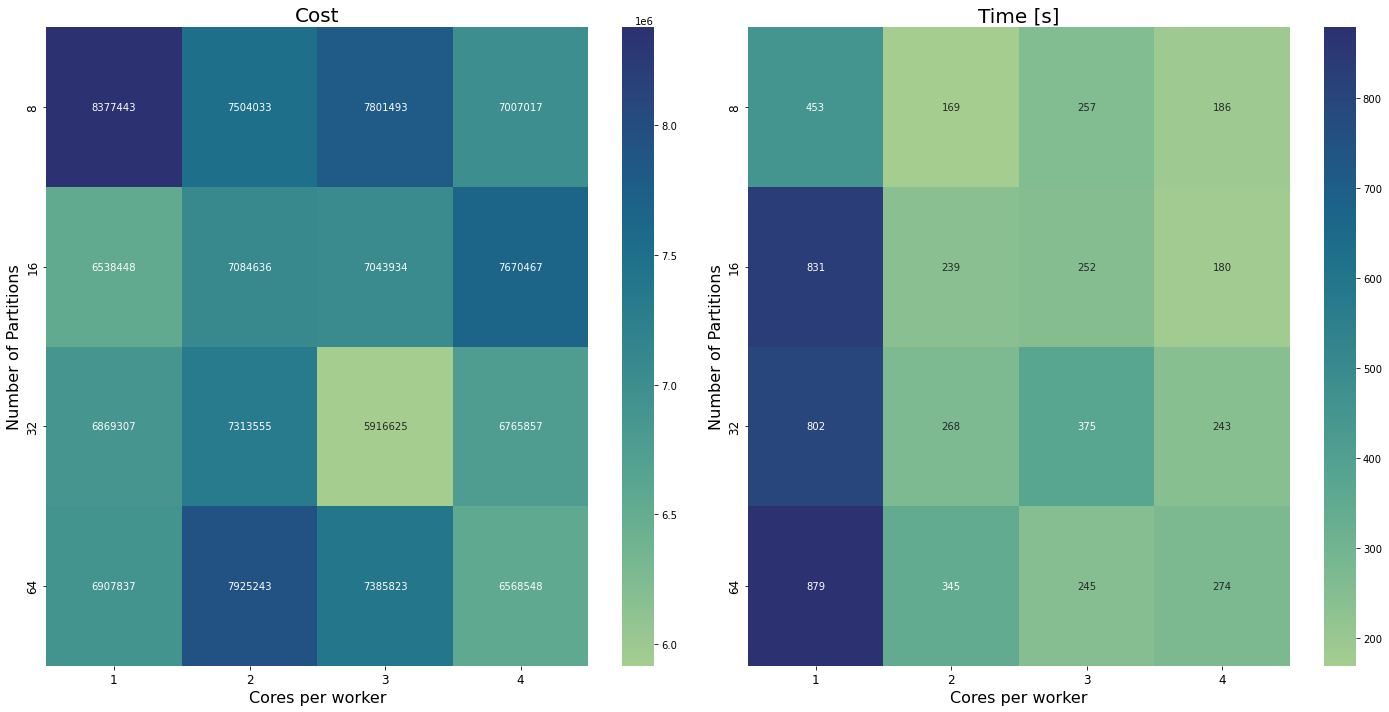

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(cost_matrix, ax=axes[0], cmap='crest', annot=True, fmt='.0f', cbar=True, yticklabels=[8,16,32,64],  
            xticklabels=[1,2,3,4])


axes[0].set_title('Cost', fontsize=20)
axes[0].set_xlabel("Cores per worker", fontsize=16)
axes[0].set_ylabel("Number of Partitions", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)


# Plot heatmap in the second subplot (bottom)
sns.heatmap(time_matrix, ax=axes[1], cmap='crest', annot=True, fmt='.0f', cbar=True, yticklabels=[8,16,32,64], 
            xticklabels=[1,2,3,4])

axes[1].set_title('Time [s]', fontsize=20)
axes[1].set_xlabel("Cores per worker", fontsize=16)
axes[1].set_ylabel("Number of Partitions", fontsize=16)
axes[1].tick_params(axis='both', labelsize=12)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()